# 🚗 Urban Autonomy: Analyzing Traffic-Interaction Patterns of Self-Driving Vehicles in the Bay Area

**Dataset:** Waymo Open Dataset - End-to-End Driving
- High-resolution multi-modal sensor data from autonomous vehicles
- 8 cameras per frame (360° coverage)
- Historical trajectory data (4 seconds at 4 Hz)
- Speed, position, and acceleration data
- Vehicle Intent



## 🔽 **Step 1**: Install and Import Packages

### 📋 Requirements
To analyze the autonomous driving data effectively, we need to establish a specific environment. The **Waymo Open Dataset** relies on Protocol Buffers and TensorFlow to parse driving logs.

**Key Libraries:**
* **TensorFlow (v2.12.0):** The backend required for the WOD data pipeline.
* **Waymo Open Dataset:** Contains the `E2EDFrame` protocol buffers and parsing logic.
* **Pandas & NumPy:** Essential for vector math (acceleration/jerk calculations) and structuring the dataset for analysis.
* **Seaborn & Matplotlib:** Used for visualizing kinematic distributions and driving scenarios.

In [1]:
!pip install --upgrade pip -q

In [2]:
!pip install --no-deps waymo-open-dataset-tf-2-12-0==1.6.7 -q

In [3]:
# Install dependencies (if needed)
# !pip install tensorflow numpy matplotlib

import tensorflow as tf
from collections import defaultdict
from tqdm.notebook import tqdm
import os

# Import Waymo dataset libraries
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2


## 🔽 **Step 2**: Load the Dataset

### 📂 Data Access & Configuration
In this step, we mount **Google Drive** to access the Waymo Open Dataset files. Since the dataset is large, we stream the data directly from the drive rather than downloading it to the local Colab instance.

**Key Parameters:**
* **`DATASET_DIR`**: The directory path where your Waymo files are stored.
* **`TFRECORD_FILE`**: The specific dataset shard (file) to analyze.
* **`NUM_SAMPLES`**: A limiter to control how many frames are processed.

> **Note:** The data is loaded using `tf.data.TFRecordDataset`. This creates a pipeline that streams records one by one, preventing memory overflow errors (OOM).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Configure dataset path
# !! Modify the following based on the location of your file
DATASET_DIR = '/content/drive/MyDrive/ECE143_Datasets/'
TFRECORD_FILE = DATASET_DIR + 'training_202504031202_202504151040.tfrecord-00000-of-00263'
NUM_SAMPLES = 1000

if not os.path.exists(TFRECORD_FILE):
    print(f"Error: File not found at {TFRECORD_FILE}")
    print("   Please check your Google Drive path.")
else:
    print(f"Found dataset: {os.path.basename(TFRECORD_FILE)}")

Found dataset: training_202504031202_202504151040.tfrecord-00000-of-00263


In [6]:
# Load TFRecord dataset
dataset = tf.data.TFRecordDataset(TFRECORD_FILE, compression_type='')

## 🔽 **Step 3**: Behavior Analysis & Classification

### 🧠 3.1 The Analysis Logic (`analyze_driving_behavior`)
This function transforms raw kinematic data from the Waymo logs into interpretable driving metrics. It performs three critical operations:

1.  **Vector Decomposition:**
    * Raw acceleration ($a_x, a_y$) is projected onto the velocity vector ($v_x, v_y$).
    * **Longitudinal:** Represents Gas (+) and Brake (-).
    * **Lateral:** Represents Steering force (centripetal acceleration).
2.  **Jerk Calculation:**
    * Calculates the rate of change of acceleration ($\Delta a / \Delta t$). High jerk indicates uncomfortable ride.
3.  **Interaction Scoring:**
    * A weighted sum that quantifies the "intensity" of a driving event.

---

### 📊 3.2 The Classification Logic (`classify_scenario`)
Once metrics are extracted, the `classify_scenario` function applies a **4-Tier Priority System**. Higher tiers override lower ones to ensure safety-critical events are never missed.

| Tier | Priority | Categories |
| :--- | :--- | :--- |
| **1** | Critical | Emergency Braking ($< -4.5 m/s^2$), Evasive Swerves |
| **2** | High | Cut-ins, Hard Launches, Erratic/Jerky Driving |
| **3** | Medium | Stop-and-Go Traffic, Lane Weaving, Normal Lane Changes |
| **4** | Low | Parking Lot, City Street, Highway Cruising (determined by speed) |

In [7]:
from scenario_classification import analyze_driving_behavior, classify_scenario

In [8]:
# Process dataset
print("Processing data...")
all_metrics = []
scenario_counts = defaultdict(int)

# 1. Dataset Iter
dataset_iter = dataset.as_numpy_iterator()
dataset_iter = iter(dataset_iter)

# 2. Process
for idx, bytes_example in tqdm(enumerate(dataset_iter), total=NUM_SAMPLES, desc="Analyzing Frames"):
    if idx >= NUM_SAMPLES: break

    try:
        data = wod_e2ed_pb2.E2EDFrame()
        data.ParseFromString(bytes_example)

        # Analysis
        metrics = analyze_driving_behavior(data)

        if metrics:
            # Classification
            scenario = classify_scenario(metrics)
            metrics['scenario'] = scenario

            # Store
            scenario_counts[scenario] += 1
            all_metrics.append(metrics)

    except Exception as e:
        print(f"Error record {idx}: {e}")
        continue

# 3. Results
print(f"\nAnalyzed {len(all_metrics)} samples")
print("-" * 55)
print(f"{'SCENARIO':<35} | {'COUNT':<5} | {'%':<5}")
print("-" * 55)
for scenario, count in sorted(scenario_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{scenario:<35} | {count:<5} | {count/len(all_metrics)*100:.1f}%")

Processing data...


Analyzing Frames:   0%|          | 0/1000 [00:00<?, ?it/s]


Analyzed 1000 samples
-------------------------------------------------------
SCENARIO                            | COUNT | %    
-------------------------------------------------------
Stop-and-Go Traffic                 | 290   | 29.0%
City Surface Street                 | 252   | 25.2%
Parking Lot / Residential Area      | 228   | 22.8%
Stationary / Idling                 | 203   | 20.3%
Fast Arterial Road                  | 18    | 1.8%
Highway Cruising                    | 9     | 0.9%


In [9]:
from baseline_plots import plot_kinematic_statics, plot_scenario_distribution

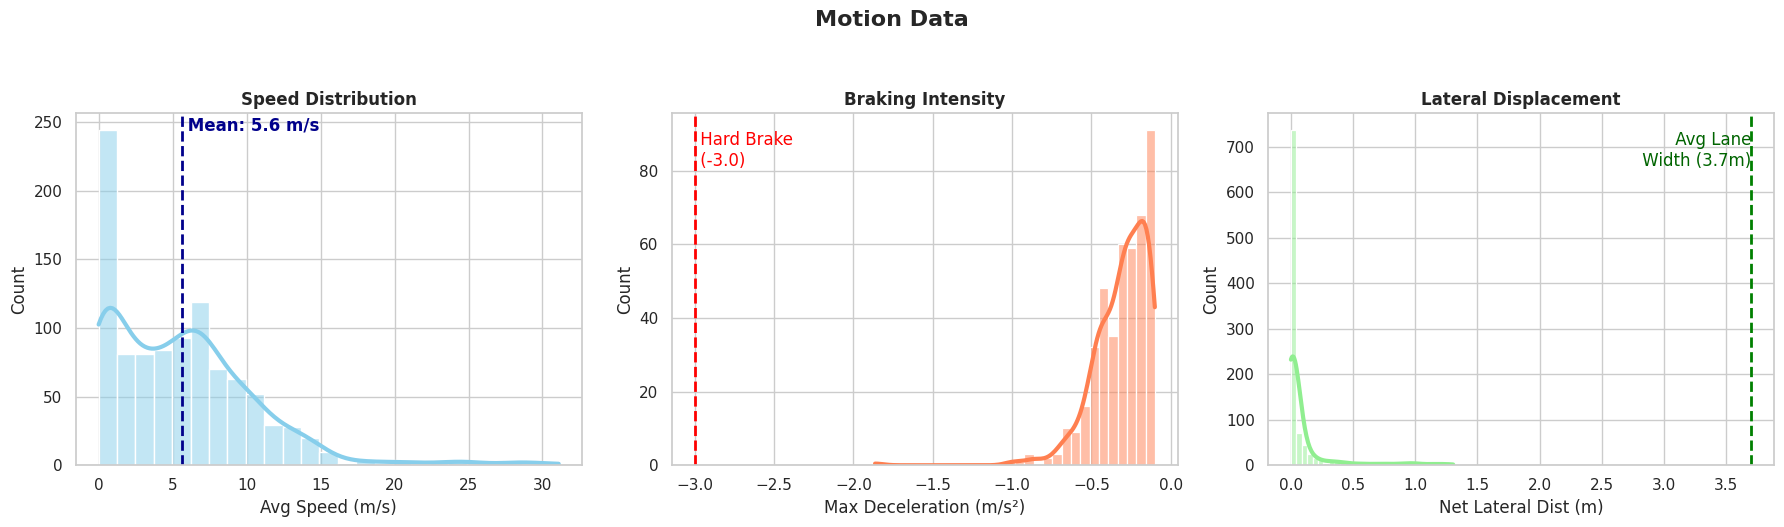

In [10]:
plot_kinematic_statics(all_metrics)

### 📊 **Driving Scenario Classification**

The classifier operates on a **Priority Waterfall** model. It checks for critical safety events first; if none are found, it checks for aggressive behavior, then traffic patterns, and finally defaults to environmental context.

#### **Tier 1: Critical Safety Events (Highest Priority)**
*These events represent near-misses, emergency maneuvers, or potential collisions. They override all other classifications.*

* **Emergency Braking**: `max_brake < -4.5 m/s²`
* **Evasive Swerve**: `Intent == STRAIGHT` and `Lateral Accel > 2.0 m/s²`

---

#### **Tier 2: Aggressive & Abnormal Behavior**
*Events where the vehicle is stable but the driving style is uncomfortable, inefficient, or dangerous.*

* **Aggressive Cut-In / Turn** :`Intent == TURN` AND `Lateral Accel > 2.5 m/s²`
* **Erratic / Jerky Driving** `Longitudinal Jerk > 4.0 m/s³` AND `Speed > 5.0 m/s`
* **Aggressive Launch**: `Accel > 3.0 m/s²` AND `Speed < 15.0 m/s`
---

#### **Tier 3: Complex Traffic Patterns**
*These classifications rely on **temporal consistency** (frame counts) rather than single peak values.*

* **Stop-and-Go Traffic**: `Decel Frames ≥ 3` AND `Speed < 9.0 m/s` (~20mph)
* **Lane Weaving / Unstable** : `Lateral Frames ≥ 2` AND `Intent == STRAIGHT`
* **Normal Lane Change**: `Lateral Frames ≥ 1` AND `Intent == TURN`

---

#### **Tier 4: Steady State Context (Default)**
*If no specific events are detected, the classifier infers the road environment based on average speed.*

| Speed Range (m/s) | Speed Range (mph) | Classification |
| :--- | :--- | :--- |
| **0.0 - 1.0** | 0 - 2 | Stationary / Idling |
| **1.0 - 7.0** | 2 - 15 | Parking Lot / Residential |
| **7.0 - 16.0** | 15 - 35 | City Surface Street |
| **16.0 - 25.0** | 35 - 55 | Fast Arterial Road |
| **> 25.0** | > 55 | Highway Cruising |

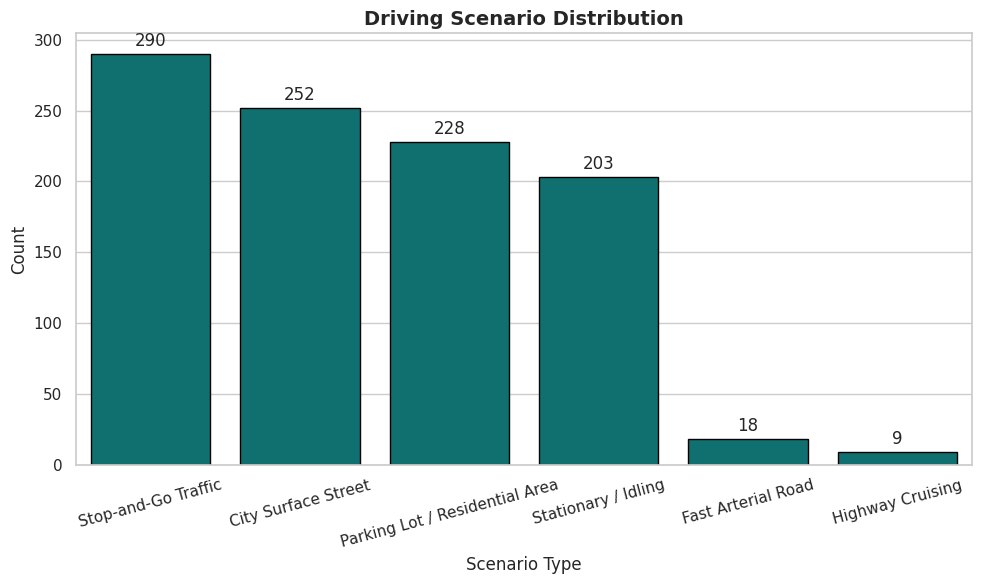

In [11]:
plot_scenario_distribution(all_metrics)

### 🎯 **Interaction Score**

A composite metric identifying scenarios where driving behavior becomes unsafe or uncomfortable for passengers.

**Equation:**
$$Score = 5 |B_{sig}| + (4 |A_{lat}| \cdot S_{factor} \cdot P_{motion}) + 0.5 J_{long} + 2 N_{lat}$$

Where:
* $B_{sig}$: Significant Braking ($< -1.0 m/s^2$)
* $A_{lat}$: Peak Lateral Acceleration
* $S_{factor}$: Speed Scaling (Higher speeds = higher risk)
* $P_{motion}$: Unexpected Motion Penalty (Swerving while signaling straight)
* $J_{long}$: Longitudinal Jerk
* $N_{lat}$: Count of significant lateral events

In [12]:
from score_distribution import plot_interaction_score, interaction_stats_table

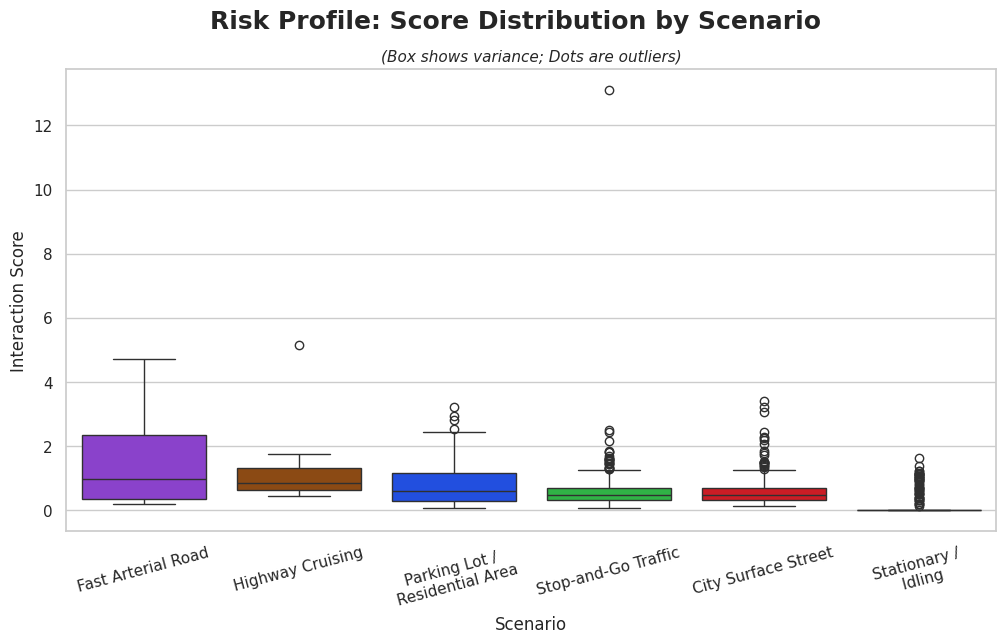

In [13]:
plot_interaction_score(all_metrics)

In [14]:
interaction_stats_table(all_metrics)


=== RISK PROFILE STATS SUMMARY ===
| scenario                       |   median |      iqr |      max |       min |
|:-------------------------------|---------:|---------:|---------:|----------:|
| Fast Arterial Road             | 0.965245 | 1.97615  |  4.73398 | 0.210468  |
| Highway Cruising               | 0.847187 | 0.692425 |  5.15208 | 0.450635  |
| Parking Lot / Residential Area | 0.600941 | 0.878319 |  3.23047 | 0.0889565 |
| Stop-and-Go Traffic            | 0.469892 | 0.373759 | 13.0888  | 0.06366   |
| City Surface Street            | 0.467989 | 0.376398 |  3.42388 | 0.139429  |
| Stationary / Idling            | 0        | 0        |  1.64022 | 0         |


### 📝 **Interaction Score Stats Summary**

| scenario                       |   median |      iqr |      max |       min |
|:-------------------------------|---------:|---------:|---------:|----------:|
| Fast Arterial Road             | 0.965245 | 1.97615  |  4.73398 | 0.210468  |
| Highway Cruising               | 0.847187 | 0.692425 |  5.15208 | 0.450635  |
| Parking Lot / Residential Area | 0.600941 | 0.878319 |  3.23047 | 0.0889565 |
| Stop-and-Go Traffic            | 0.469892 | 0.373759 | 13.0888  | 0.06366   |
| City Surface Street            | 0.467989 | 0.376398 |  3.42388 | 0.139429  |
| Stationary / Idling            | 0        | 0        |  1.64022 | 0         |

## 📊 Visualization 2: High-Interaction Zone Analysis


In [15]:
from interaction_validation import plot_interaction

Visualizing 100 Critical Events (Score > 1.3)


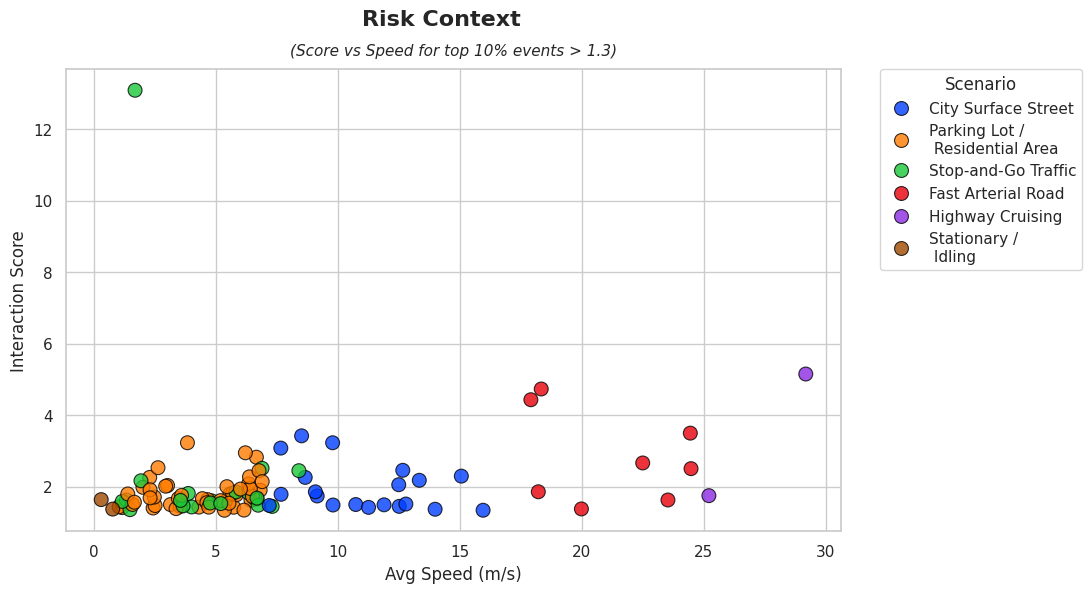

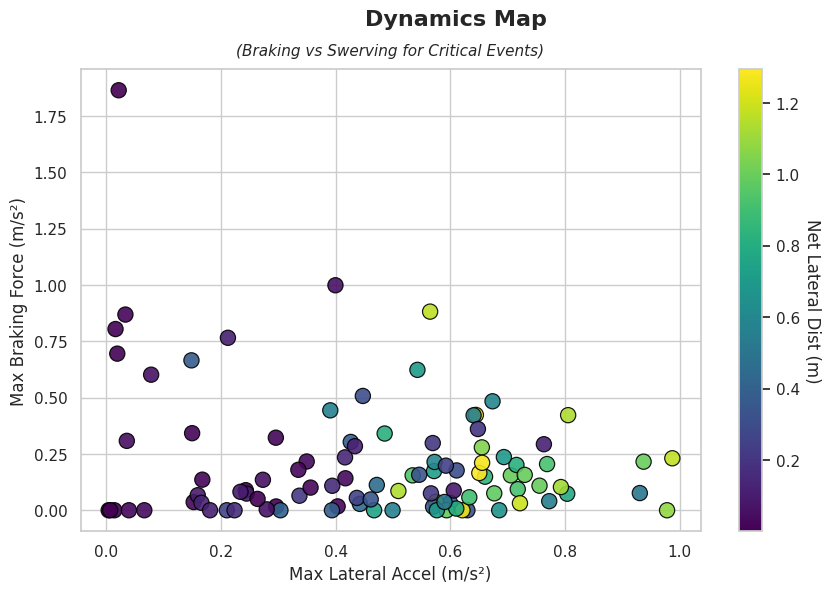

In [16]:
plot_interaction(all_metrics)

## 🔽 **Step 4**: High Interaction Zone Visualization

### 📊 4.1 Aggregate Risk Analysis
Now that we have scored every event, we filter for the **Top 10%** of high-interaction scenarios. This step generates two key visualizations to help us understand the "Risk Profile" of the autonomous vehicle.

1.  **Risk Context (Speed vs. Score):**
    * Maps *where* the high-stress events occur (Residential vs. Highway speeds).
    * **X-Axis:** Vehicle Speed.
    * **Color:** The classified scenario (e.g., Cut-In, Stop-and-Go).
2.  **Dynamics Map (Braking vs. Swerving):**
    * Visualizes the vehicle's physical reaction to stress.
    * **Y-Axis:** Braking Force (Longitudinal).
    * **X-Axis:** Steering Force (Lateral).

> **📝 Key Findings from Analysis:**
> * **Stability (No Panic):** Even in high-stress events, the vehicle exhibits zero hard braking (>3 m/s²) or evasive swerving.
> * **Speed Modulation:** The AV successfully manages high interaction by lowering speeds, primarily in City and Residential environments.

In [17]:
from visualization import trajectory_visualization

Generating trajectory visualization for Top 3 Events...
Found Event 1/3: f0941b3325e0eaef565fe5a3ed43f664-147 (Score: 13.09)


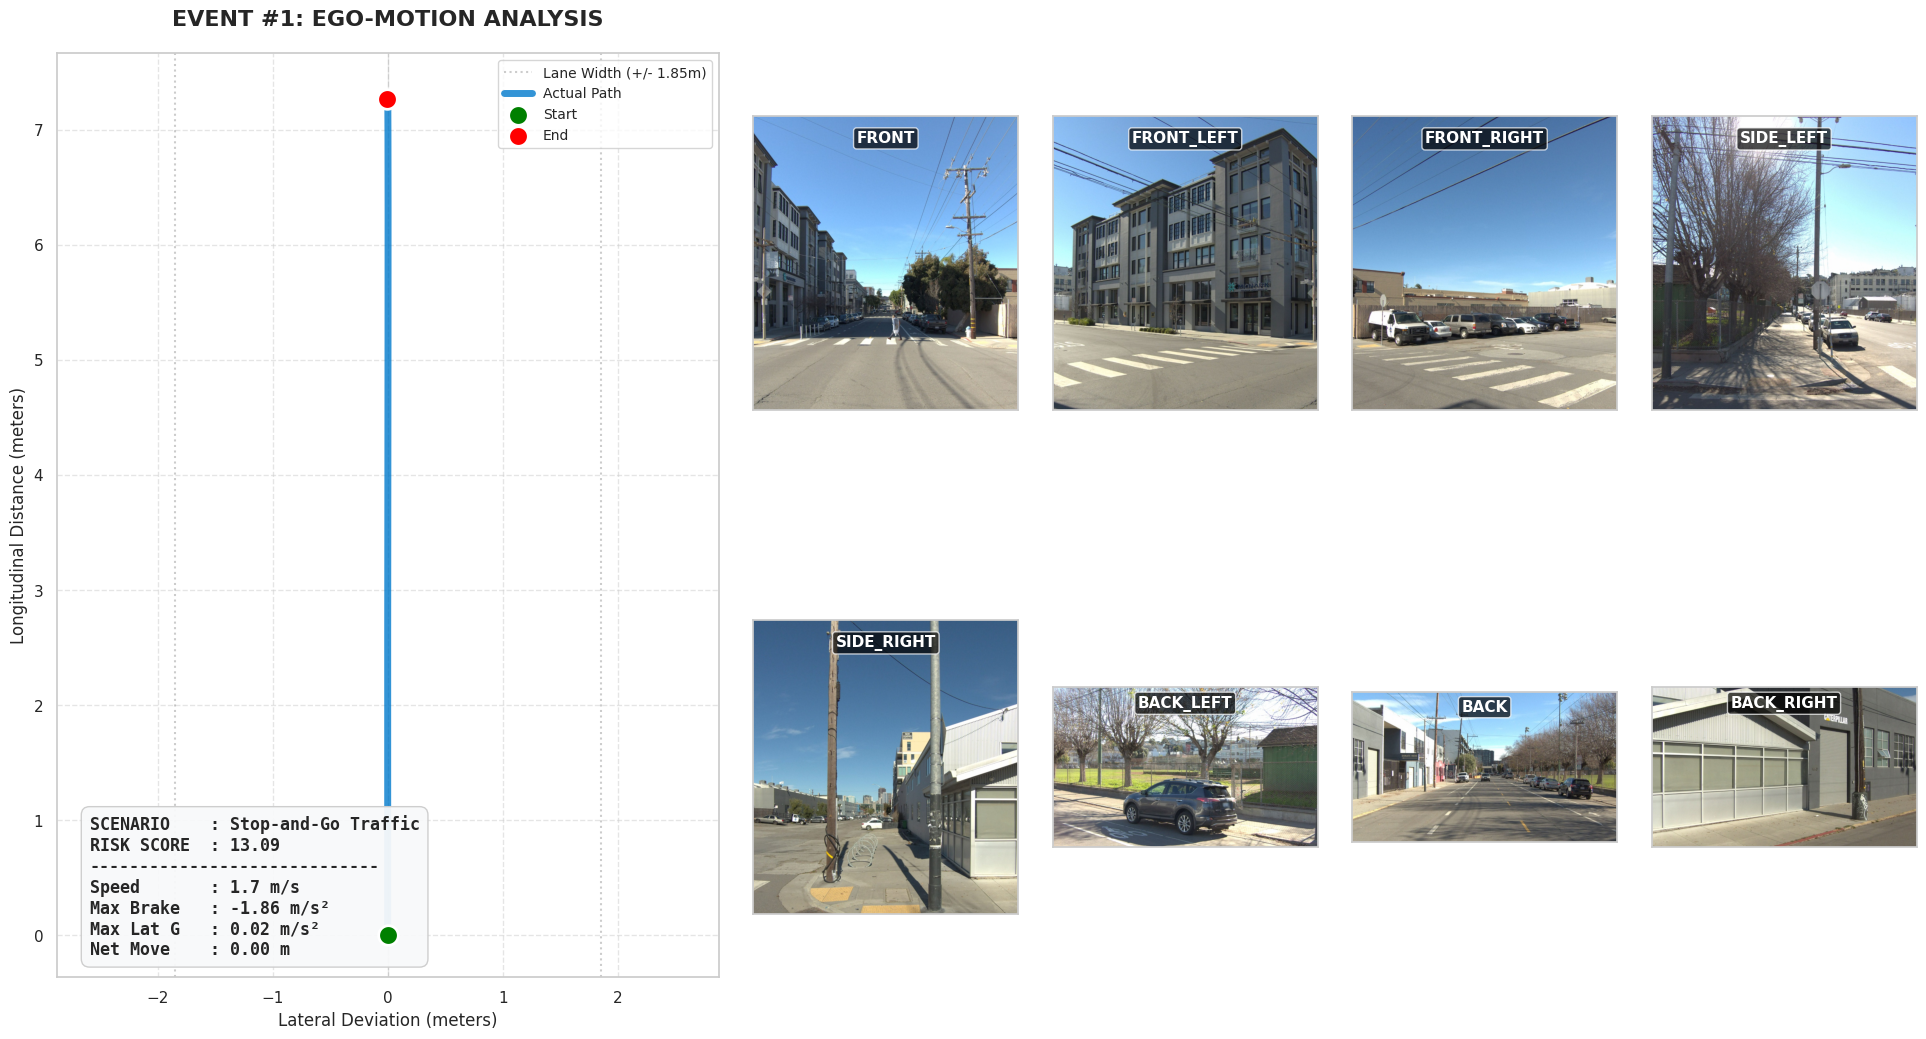

Found Event 2/3: 1dc0dd10757270c34b550f09a383c5f4-070 (Score: 4.73)


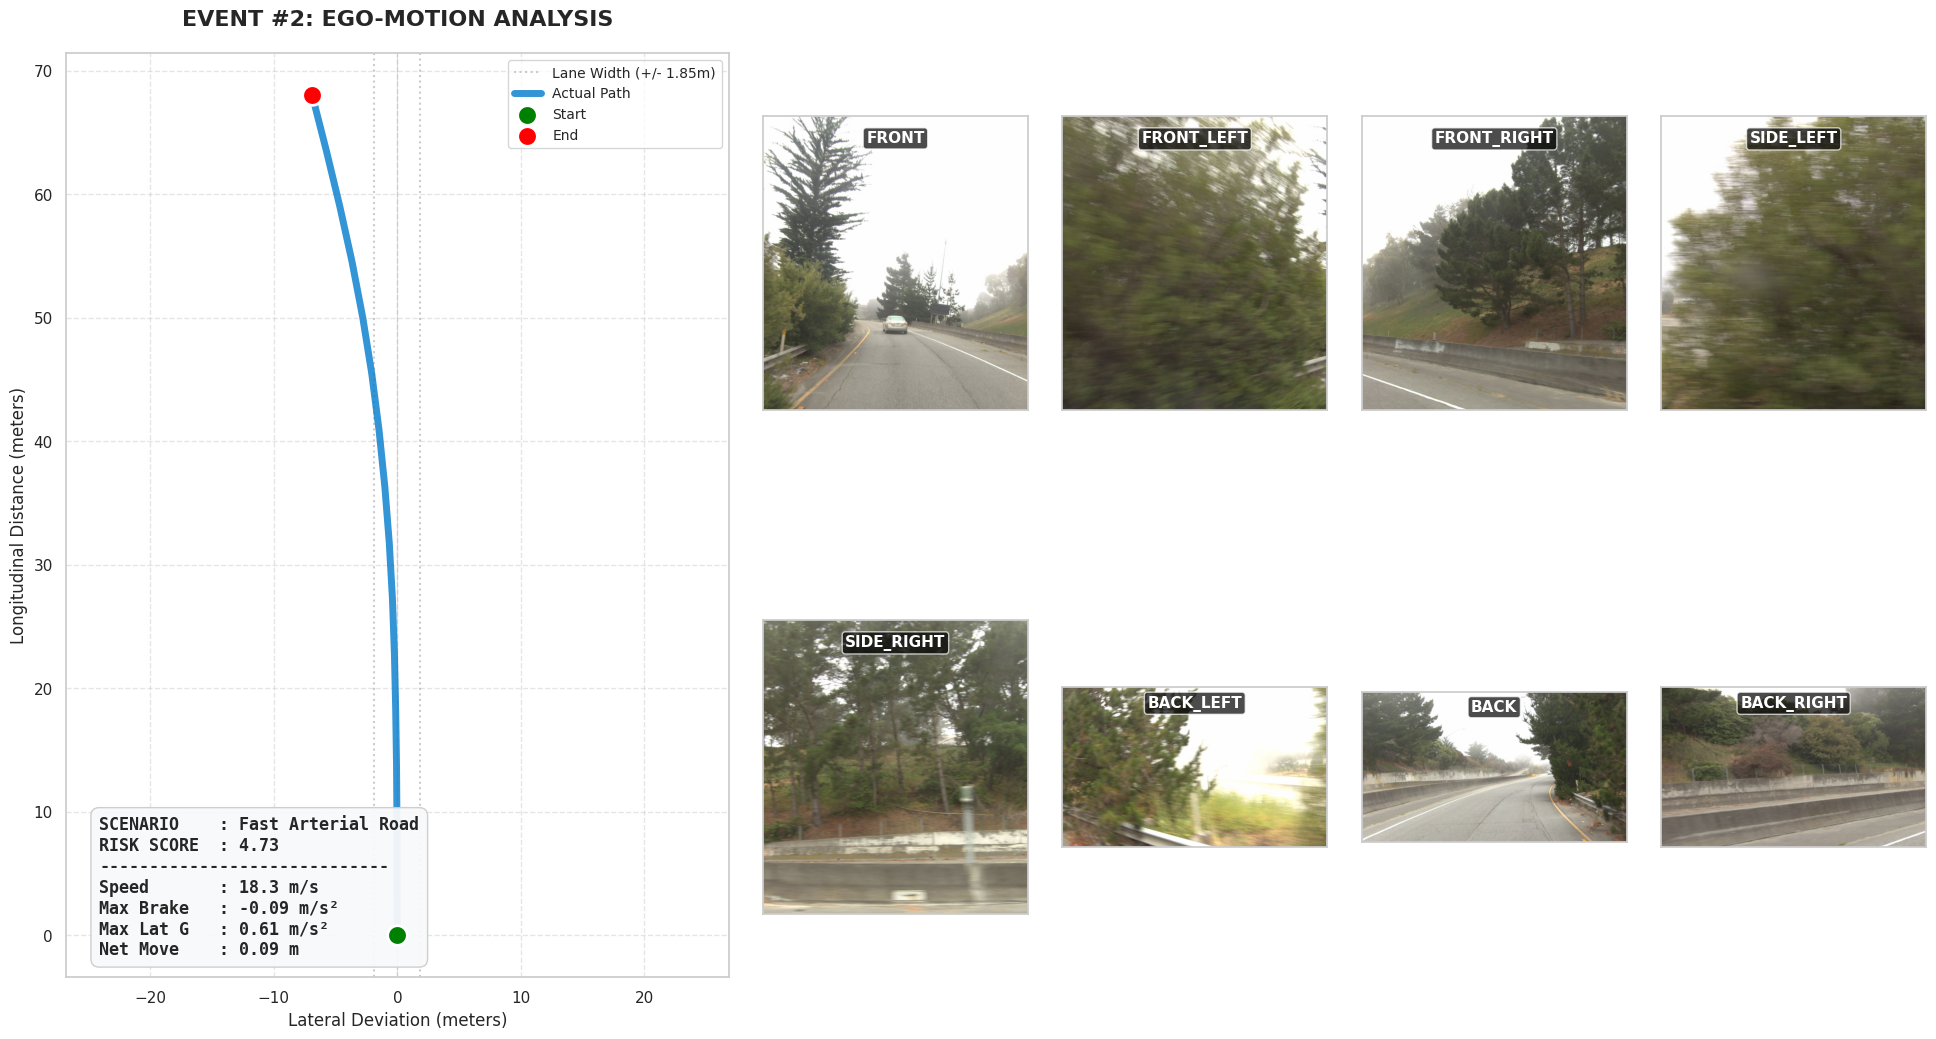

Found Event 3/3: 3b90315089874e427e6b0599c1496fd6-105 (Score: 5.15)


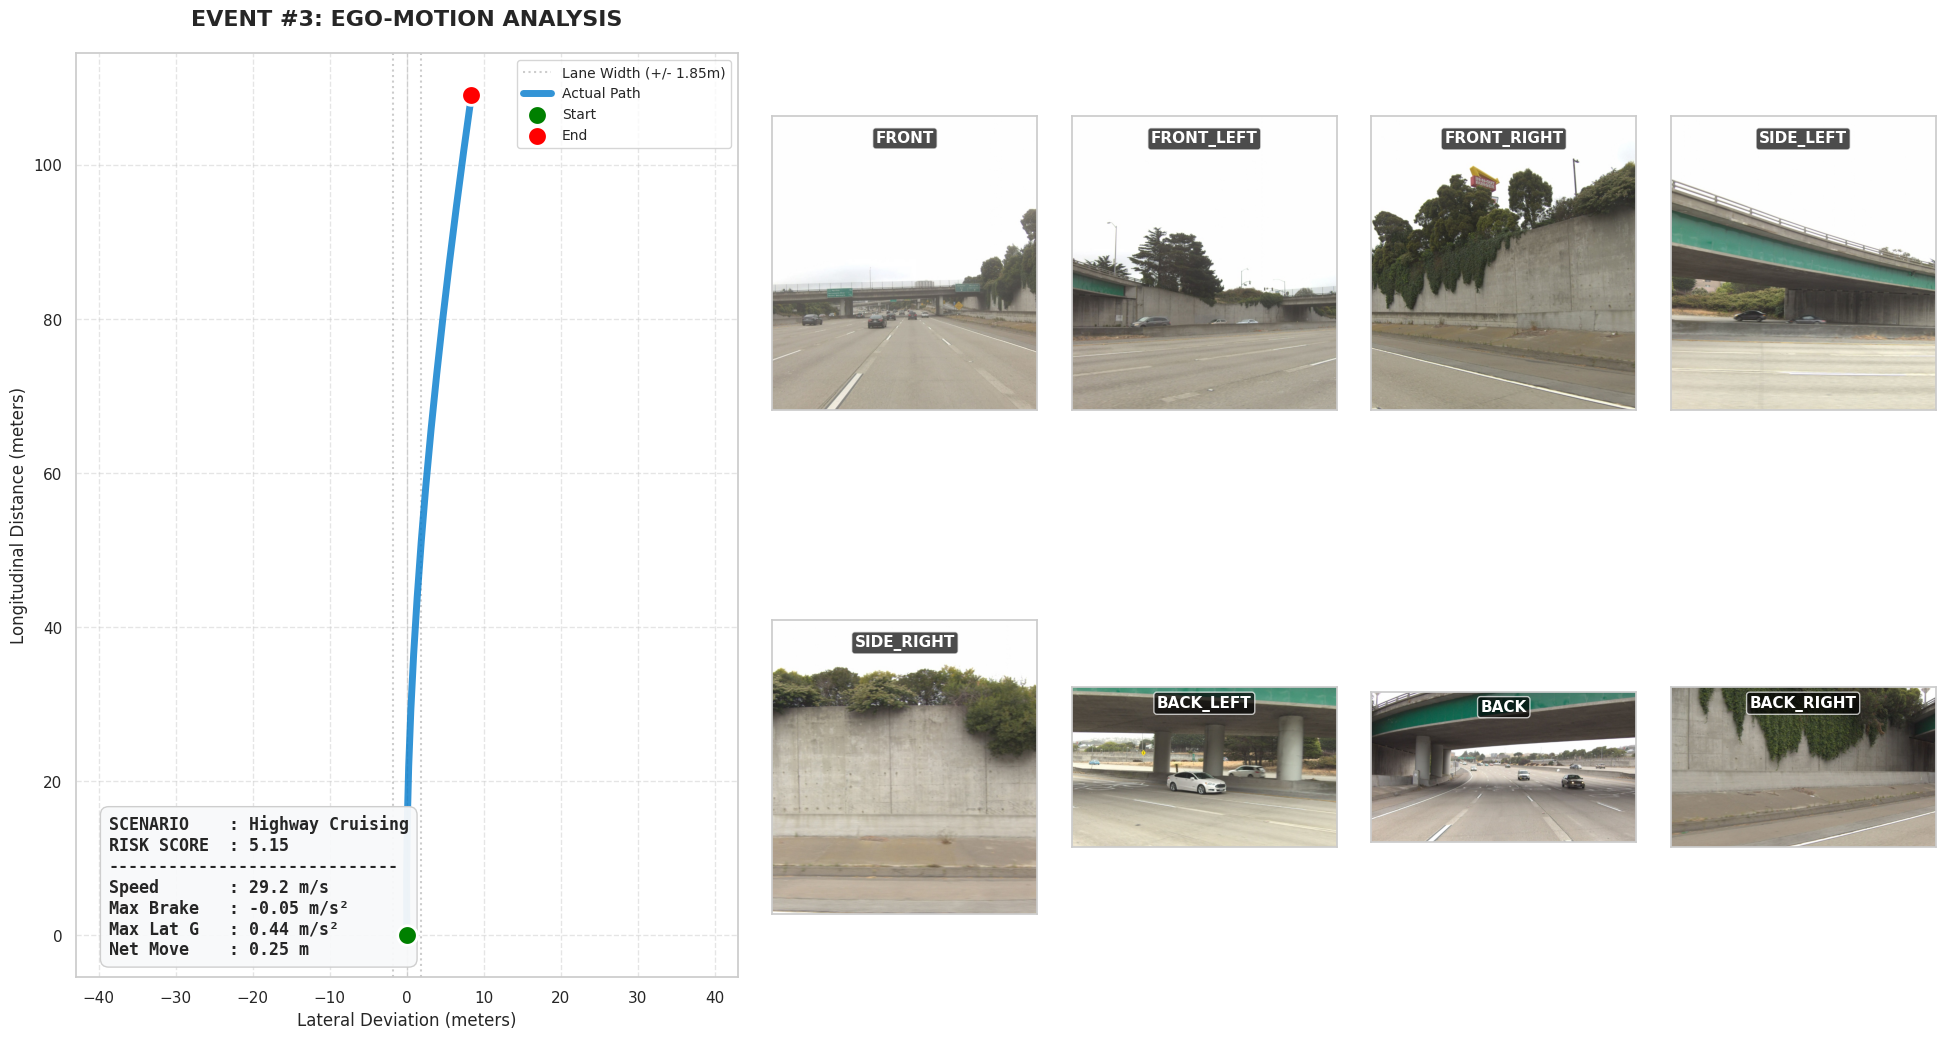

In [ ]:
trajectory_visualization(dataset, all_metrics, top_n=3)